# MATH 509 project

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import librosa
import librosa.display


In [3]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")

No GPU was detected. CNNs can be very slow without a GPU.


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
PROJECT_PATH= "/content/drive/MyDrive/Math_509/Math_509_Project"

In [42]:
%cd $PROJECT_PATH

/content/drive/MyDrive/Math_509/Math_509_Project


In [7]:
import utils #load local package

## 1 Preparing datasets

### 1.1 Geting datasets

In [5]:
import zipfile

files = zipfile.ZipFile(PROJECT_PATH + '/data/fma_metadata.zip', 'r')
files.printdir()

File Name                                             Modified             Size
fma_metadata/README.txt                        2017-04-01 00:00:00          256
fma_metadata/checksums                         2017-04-01 00:00:00          563
fma_metadata/not_found.pickle                  2017-04-01 00:00:00       216942
fma_metadata/raw_genres.csv                    2017-04-01 00:00:00         5866
fma_metadata/raw_albums.csv                    2017-04-01 00:00:00     24144296
fma_metadata/raw_artists.csv                   2017-04-01 00:00:00     14044281
fma_metadata/raw_tracks.csv                    2017-04-01 00:00:00    122246181
fma_metadata/tracks.csv                        2017-04-01 00:00:00    260414445
fma_metadata/genres.csv                        2017-04-01 00:00:00         3922
fma_metadata/raw_echonest.csv                  2017-04-01 00:00:00     48642077
fma_metadata/echonest.csv                      2017-04-01 00:00:00     44000447
fma_metadata/features.csv               

In [15]:
tracksCSV = files.open('fma_metadata/tracks.csv') #get a csv dataset from zip
genresCSV = files.open('fma_metadata/genres.csv')
featuresCSV = files.open('fma_metadata/features.csv')
echonestCSV = files.open('fma_metadata/echonest.csv')

In [16]:
tracks=utils.load(tracksCSV,"tracks")
genres=utils.load(genresCSV,"genres")
features=utils.load(featuresCSV,"features")
echonest=utils.load(echonestCSV,"echonest")

In [17]:
print(tracks.shape,genres.shape,features.shape,echonest.shape)

(106574, 52) (163, 4) (106574, 518) (13129, 249)


In [18]:
tracks.head(5)

album                      ... track                 
         comments        date_created  ...  tags            title
track_id                               ...                       
2               0 2008-11-26 01:44:45  ...    []             Food
3               0 2008-11-26 01:44:45  ...    []     Electric Ave
5               0 2008-11-26 01:44:45  ...    []       This World
10              0 2008-11-26 01:45:08  ...    []          Freeway
20              0 2008-11-26 01:45:05  ...    []  Spiritual Level

[5 rows x 52 columns]

In [12]:
genres.head(3)

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3


In [13]:
features.head(3)

feature    chroma_cens                      ...  zcr                    
statistics    kurtosis                      ...  min      skew       std
number              01        02        03  ...   01        01        01
track_id                                    ...                         
2             7.180653  5.230309  0.249321  ...  0.0  2.089872  0.061448
3             1.888963  0.760539  0.345297  ...  0.0  1.716724  0.069330
5             0.527563 -0.077654 -0.279610  ...  0.0  2.193303  0.044861

[3 rows x 518 columns]

In [14]:
echonest['echonest', 'audio_features'].head(3)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661


In [ ]:
# SmallMp3Arch = zipfile.ZipFile('/content/drive/MyDrive/Math_509/Project/data/fma_small.zip', 'r')
# SmallMp3Arch.extractall("/content/drive/MyDrive/Math_509/Project/data")

### 1.2 Processing datasets

In [20]:
SeleTracks=tracks[tracks['set', 'subset'] <= 'small']
SeleTracks.shape

(8000, 52)

In [21]:
SLmeta=pd.DataFrame()
SLmeta=SeleTracks["track"][["title","genres","genres_all"]] #"genre_top"
SLmeta["artist"]=SeleTracks["artist","name"]
SLmeta.shape

(8000, 4)

In [22]:
SLmetaWithfeatures=SLmeta.merge(echonest['echonest', 'audio_features'],on="track_id",) # merge audio_features data
MFdata=SLmetaWithfeatures.dropna().reset_index()
MFdata

,track_id,title,genres,genres_all,artist,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,Food,[21],[21],AWOL,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,5,This World,[21],[21],AWOL,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
2,10,Freeway,[10],[10],Kurt Vile,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
3,140,Queen Of The Wires,[17],[17],Alec K. Redfearn & the Eyesores,0.376312,0.734079,0.265685,0.669581,0.085995,0.039068,107.952,0.609991
4,141,Ohio,[17],[17],Alec K. Redfearn & the Eyesores,0.963657,0.435933,0.075632,0.345493,0.105686,0.026658,33.477,0.163950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,123821,...E Você Espera Por Tanto Tempo Que Já Não Le...,[26],"[26, 12]",E A Terra Nunca Me Pareceu Tão Distante,0.737893,0.372404,0.329644,0.919781,0.104495,0.031262,111.243,0.037006
1290,124180,No Doubt,[18],"[18, 1235]",Jelsonic,0.719748,0.743468,0.470952,0.036896,0.112698,0.438508,173.851,0.810091
1291,124184,Heist,[31],"[12, 31]",Bloodgod,0.022261,0.638672,0.955109,0.802745,0.352897,0.072761,124.996,0.143388
1292,124185,Wrecking Ball Surprise,[31],"[12, 31]",Bloodgod,0.032193,0.670471,0.968672,0.781511,0.212983,0.052916,95.066,0.319052


In [45]:
MFdata.to_json(PROJECT_PATH + "/data/MFdata.json")

In [6]:
MFdata=pd.read_json(PROJECT_PATH + "/data/MFdata.json")

In [7]:
import tqdm.notebook as tqdm

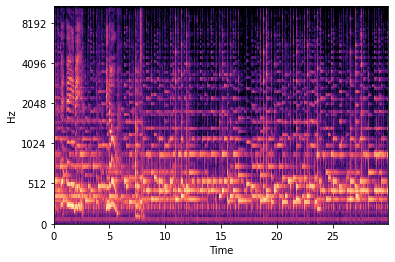

In [49]:
data_path=PROJECT_PATH +"/data/fma_small"
trackid=MFdata["track_id"].values[10]
path=utils.get_audio_path(data_path,trackid)
y, sr =librosa.load(path, sr=SAMPLE_RATE, mono=True)
spect = librosa.feature.melspectrogram(y=y[0:660984], sr=sr,n_fft=2048, hop_length=512)
db_mel = librosa.power_to_db(spect, ref=np.max)
librosa.display.specshow(db_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

In [142]:
db_mel.shape

(128, 1291)

In [47]:
SAMPLE_RATE=22050

In [131]:

data_path=PROJECT_PATH +"/data/fma_small"

melfqlist=[]
nplist=[]
for tid in tqdm.tqdm(MFdata["track_id"].values):
  path=utils.get_audio_path(data_path,tid)
  y, sr =librosa.load(path, sr=SAMPLE_RATE, mono=True)
  spect = librosa.feature.melspectrogram(y=y[0:660984], sr=sr,n_fft=2048, hop_length=512)
  spect = librosa.power_to_db(spect, ref=np.max)
  # mfcc = sk.preprocessing.StandardScaler().fit_transform(spect)
  nplist.append(spect.flatten())
  #melfqlist.append([tid,spect])

  0%|          | 0/1294 [00:00<?, ?it/s]

In [132]:
npmelfeq=np.array(nplist)
np.save(PROJECT_PATH + "/data/melfeq.npy",npmelfeq)

## 2 Prepare Training,Testing Sets

In [50]:
melfeq=np.load(PROJECT_PATH + "/data/melfeq.npy")

In [51]:
MFdata=pd.read_json(PROJECT_PATH + "/data/MFdata.json")
col_n=["acousticness"	,"danceability"	,"energy"	,"instrumentalness",	"liveness",	"speechiness"	,"tempo",	"valence"]
outData=pd.DataFrame(MFdata,columns=col_n)

In [52]:
outData.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000
mean,0.535750,0.515650,0.504199,0.586719,0.194898,0.091339,121.568431,0.444944
std,0.386509,0.188086,0.256024,0.387338,0.171615,0.118443,35.127952,0.278663
min,0.000002,0.051307,0.001308,0.000000,0.028475,0.023234,19.659000,0.021404
25%,0.103872,0.382811,0.303788,0.093467,0.101974,0.034849,95.017000,0.203670
50%,0.612725,0.518369,0.490024,0.801824,0.118862,0.044233,119.990000,0.407616
75%,0.935562,0.656169,0.704464,0.917227,0.214865,0.081578,141.970750,0.681314
max,0.995796,0.961871,0.998563,0.988947,0.960519,0.959222,250.059000,0.991132


In [53]:
outData.values.shape

(1294, 8)

In [54]:
InputScaler=sk.preprocessing.Normalizer(norm="max")
InputNorm=InputScaler.fit_transform(melfeq)

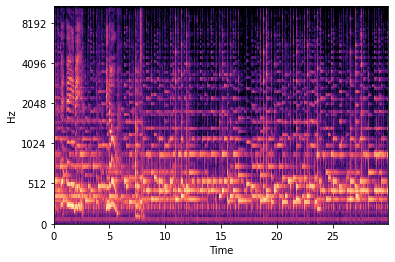

In [57]:
inDataNorm=InputNorm.reshape(1294,128,1291) 
librosa.display.specshow(inDataNorm[10], hop_length=512, x_axis='time', y_axis='mel'); #verifying whether the input dataset is correct

In [58]:
inDataNorm=inDataNorm*-1 # convert {-1,0} to 0,1

In [19]:
inDataNorm.max()

1.0

### 2.1 Normalizer output data

In [59]:
OutputScaler=sk.preprocessing.Normalizer(norm="max")

In [60]:
outDataNorm=OutputScaler.fit_transform(outData.values.T).T

In [61]:
outDataNorm=pd.DataFrame(outDataNorm,columns=col_n)

In [62]:
outDataNorm.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000
mean,0.538012,0.536091,0.504924,0.593276,0.202909,0.095222,0.486159,0.448925
std,0.388140,0.195542,0.256392,0.391667,0.178669,0.123478,0.140479,0.281156
min,0.000002,0.053341,0.001310,0.000000,0.029646,0.024221,0.078617,0.021596
25%,0.104310,0.397986,0.304225,0.094511,0.106166,0.036330,0.379978,0.205492
50%,0.615311,0.538918,0.490730,0.810785,0.123748,0.046113,0.479847,0.411263
75%,0.939511,0.682180,0.705478,0.927479,0.223697,0.085046,0.567749,0.687410
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
outDataNorm.to_numpy().shape

(1294, 8)

### 2.2 Split datasets

In [64]:
X_train, X_test, y_train, y_test=sk.model_selection.train_test_split(inDataNorm,outDataNorm.to_numpy(),test_size=0.2,random_state=34,shuffle=True)

In [65]:
X_train.shape

(1035, 128, 1291)

## 3 Building model

In [66]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.7.0
Running on TPU  ['10.12.234.178:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.12.234.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.234.178:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [69]:
reduce_stopping_cb = keras.callbacks.ReduceLROnPlateau('val_accuracy',     #gradually reduce the learning rate 
                              patience=4,
                              factor=0.7,
                              min_lr=0.00001)

early_stopping_cb=keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        patience=5,verbose=1, mode='auto')
checkpoint_cb = keras.callbacks.ModelCheckpoint(PROJECT_PATH +"/train_data/tf2.h5", save_best_only=True)

In [70]:
from functools import partial
def create_model():
  DefaultConv2D = partial(keras.layers.Conv2D,
                          kernel_size=3, activation='relu', padding="SAME")

  model = keras.models.Sequential([                      
      DefaultConv2D(filters=64, kernel_size=10, input_shape=[128, 1291, 1]),
      keras.layers.MaxPooling2D(pool_size=2),
      keras.layers.Dropout(0.2),
      DefaultConv2D(filters=128),
      DefaultConv2D(filters=128),
      keras.layers.MaxPooling2D(pool_size=2),
      keras.layers.Dropout(0.2),
      DefaultConv2D(filters=256),
      DefaultConv2D(filters=256),
      keras.layers.MaxPooling2D(pool_size=2),
      keras.layers.Flatten(),
      keras.layers.Dense(units=128, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(units=64, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(units=8, activation='sigmoid'),
  ])

  model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])

  return model

In [71]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model=create_model()
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 1291, 64)     6464      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 645, 64)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 645, 64)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 645, 128)      73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 645, 128)      147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 322, 128)     0         
 2D)                                                  

Learning rate per epoch:


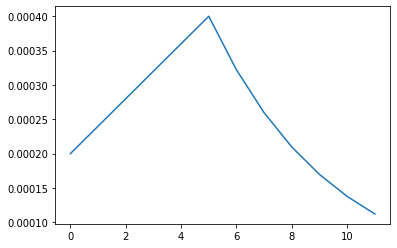

In [72]:
EPOCHS = 12

start_lr = 0.0002
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [73]:
kf = KFold(n_splits=5)
historylist=[]
for fold_train_idx, fold_val_idx in kf.split(X_train): #cross validation
  print("###################################")
  history = model.fit(X_train[fold_train_idx], y_train[fold_train_idx], 
              batch_size=5,epochs=EPOCHS,
              validation_data=[X_train[fold_val_idx], y_train[fold_val_idx]],
              callbacks=[checkpoint_cb,lr_callback,early_stopping_cb])
  historylist.append(history)

###################################

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/12
166/166 [==============================] - 43s 183ms/step - loss: 0.0776 - accuracy: 0.2246 - val_loss: 0.0689 - val_accuracy: 0.3237 - lr: 2.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.00024.
Epoch 2/12
166/166 [==============================] - 21s 130ms/step - loss: 0.0727 - accuracy: 0.2319 - val_loss: 0.0681 - val_accuracy: 0.3237 - lr: 2.4000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.00028000000000000003.
Epoch 3/12
166/166 [==============================] - 15s 90ms/step - loss: 0.0709 - accuracy: 0.2886 - val_loss: 0.0685 - val_accuracy: 0.3382 - lr: 2.8000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.00032.
Epoch 4/12
166/166 [==============================] - 28s 167ms/step - loss: 0.0686 - accuracy: 0.3140 - val_loss: 0.0619 - val_accuracy: 0.4444 - lr: 3.2000e-04

Epoch 00005: LearningR

In [127]:
historylist

## 4 testing model

In [31]:
model.load_weights(PROJECT_PATH +"/train_data/tf2.h5")

In [75]:

score, acc = model.evaluate(X_test, y_test)
#score, acc = model.evaluate(inDataNorm,outDataNorm.to_numpy())
print(score, acc)

9/9 [==============================] - 1s 45ms/step - loss: 0.0507 - accuracy: 0.4517
0.05071097984910011 0.4517374634742737
